In [11]:
# bibliotecas
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models, layers

from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

### Carregamento e Pré-Processamento do Dataset

In [2]:
from utils.data_utils_keras import load_and_preprocess_data_tf, ModelType

batch_size = 64
image_size = (224, 224)
train_ds, test_ds = load_and_preprocess_data_tf(resize_to=image_size,
                                                batch_size=batch_size,
                                                model_type=ModelType.EFFICIENTNET_B0)

Found 100000 files belonging to 2 classes.


I0000 00:00:1748946757.645962  989651 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3647 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
I0000 00:00:1748946757.646378  989651 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 3588 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Found 20000 files belonging to 2 classes.


### Divisão Holdout

In [3]:
total_batches = tf.data.experimental.cardinality(train_ds).numpy()
total_samples = total_batches * batch_size

In [4]:
# Define proporção de treino (70%) e validação (30%) usando o número de batches
train_batches = int(total_batches * 0.7)
val_batches = total_batches - train_batches

In [5]:
# Embaralha os batches do dataset
train_ds_shuffled = train_ds.shuffle(buffer_size=1000, seed=42, reshuffle_each_iteration=False)

In [6]:
# Divisão trenio e validação
train_ds = train_ds_shuffled.take(train_batches)
val_ds = train_ds_shuffled.skip(train_batches)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [7]:
print(f"Batches de treino: {train_batches}")
print(f"Batches de validação: {val_batches}")
print(f"Aproximadamente {train_batches * batch_size} amostras de treino")
print(f"Aproximadamente {val_batches * batch_size} amostras de validação")

Batches de treino: 1094
Batches de validação: 469
Aproximadamente 70016 amostras de treino
Aproximadamente 30016 amostras de validação


## Treino

### Modelo

**EfficientNetB0**

EfficientNet é uma família de CNNs que visa alcançar alto desempenho com menos recursos computacionais em comparação com arquiteturas anteriores. Foi apresentada por Mingxing Tan e Quoc V. Le, do Google Research, em seu artigo de 2019 "EfficientNet: Repensando o Escalonamento de Modelos para Redes Neurais Convolucionais". A ideia central por trás do EfficientNet é um novo método de escalonamento que escalona uniformemente todas as dimensões de profundidade, largura e resolução usando um coeficiente composto.

O EfficientNet utiliza uma técnica chamada coeficiente composto para escalonar modelos de maneira simples, mas eficaz. Em vez de escalonar aleatoriamente a largura, a profundidade ou a resolução, o escalonamento composto escalona uniformemente cada dimensão com um conjunto fixo de coeficientes de escalonamento. Usando esse método de escalonamento e o AutoML, os autores do EfficientNet desenvolveram sete modelos de várias dimensões, que superaram a precisão de ponta da maioria das CNNs e com eficiência muito superior.

A rede EfficientNet-B0 é composta por três partes principais: o Stem, o Body e o Head.

O Stem é a camada inicial da rede, composta por uma convolução padrão com 32 filtros, tamanho de kernel 3x3 e stride 2, seguida por uma normalização em batch (batch normalization) e uma função de ativação ReLU6. O Body consiste em uma série de blocos MBConv com diferentes configurações. Esses blocos utilizam convoluções depthwise separáveis, que reduzem a complexidade computacional, e camadas squeeze-and-excitation, que ajudam a rede a focar nos canais mais relevantes. Cada bloco MBConv é definido por parâmetros como o fator de expansão (que determina o quanto os canais de entrada são expandidos), o tamanho do kernel da convolução, o stride (passo da convolução) e a razão SE (squeeze-and-excitation), que controla a intensidade da recalibração dos canais. O Head é composto por um bloco final de convolução, seguido por uma camada de pooling médio global (global average pooling). Por fim, há uma camada totalmente conectada (fully connected) com uma função de ativação softmax, que realiza a classificação final.

Fonte: https://www.geeksforgeeks.org/efficientnet-architecture/

In [8]:
device = "GPU" if len(tf.config.list_physical_devices("GPU")) > 0 else "CPU"
print(f"Usando: {device}")

Usando: GPU


In [9]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid') 
])

early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5,           
    restore_best_weights=True
)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=batch_size,
    verbose=1
    callbacks=[early_stopping]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10


2025-06-03 10:33:02.960798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 46 of 1000
2025-06-03 10:33:22.766767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 132 of 1000
2025-06-03 10:33:42.919556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 219 of 1000
2025-06-03 10:33:53.018061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 264 of 1000
2025-06-03 10:34:12.868459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 352 of 1000
2025-06-03 10:34:32.747498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5096 - loss: 0.6952

2025-06-03 10:45:16.236846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 24 of 1000
2025-06-03 10:45:26.561646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 52 of 1000
2025-06-03 10:45:46.391967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 101 of 1000
2025-06-03 10:45:56.399055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 128 of 1000
2025-06-03 10:46:06.437868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 154 of 1000
2025-06-03 10:46:26.288368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5429 - loss: 0.6844

2025-06-03 11:09:07.461239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 23 of 1000
2025-06-03 11:09:27.335947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 80 of 1000
2025-06-03 11:09:37.467581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 112 of 1000
2025-06-03 11:09:57.694291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 168 of 1000
2025-06-03 11:10:17.275230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 230 of 1000
2025-06-03 11:10:27.852089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1393s 870ms/step - accuracy: 0.5429 - loss: 0.6844 - val_accuracy: 0.6490 - val_loss: 0.6690
Epoch 3/10


2025-06-03 11:20:31.604379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 25 of 1000
2025-06-03 11:20:41.579858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 57 of 1000
2025-06-03 11:21:01.282916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 118 of 1000
2025-06-03 11:21:11.340576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 148 of 1000
2025-06-03 11:21:21.634407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 181 of 1000
2025-06-03 11:21:41.927138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.5680 - loss: 0.6715

2025-06-03 11:33:11.395647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 22 of 1000
2025-06-03 11:33:21.662368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 52 of 1000
2025-06-03 11:33:41.789704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 111 of 1000
2025-06-03 11:34:01.566185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 171 of 1000
2025-06-03 11:34:21.469900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 229 of 1000
2025-06-03 11:34:31.642055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1457s 918ms/step - accuracy: 0.5680 - loss: 0.6715 - val_accuracy: 0.7016 - val_loss: 0.6402
Epoch 4/10


2025-06-03 11:44:48.729434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 25 of 1000
2025-06-03 11:45:08.373109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 81 of 1000
2025-06-03 11:45:18.657086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 112 of 1000
2025-06-03 11:45:38.446071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 184 of 1000
2025-06-03 11:45:58.397058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 264 of 1000
2025-06-03 11:46:08.736108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5752 - loss: 0.6666

2025-06-03 11:56:38.520260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 19 of 1000
2025-06-03 11:56:48.534255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 50 of 1000
2025-06-03 11:57:08.438085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 110 of 1000
2025-06-03 11:57:18.653811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 141 of 1000
2025-06-03 11:57:28.799859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 170 of 1000
2025-06-03 11:57:38.857632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1397s 873ms/step - accuracy: 0.5752 - loss: 0.6666 - val_accuracy: 0.7060 - val_loss: 0.6310
Epoch 5/10


2025-06-03 12:08:06.899368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 20 of 1000
2025-06-03 12:08:17.354430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 50 of 1000
2025-06-03 12:08:36.785826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 107 of 1000
2025-06-03 12:08:47.136815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 137 of 1000
2025-06-03 12:09:07.056483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 212 of 1000
2025-06-03 12:09:26.880155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5822 - loss: 0.6614

2025-06-03 12:19:38.331379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 20 of 1000
2025-06-03 12:19:58.182562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 85 of 1000
2025-06-03 12:20:18.229989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 140 of 1000
2025-06-03 12:20:28.239463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 169 of 1000
2025-06-03 12:20:48.312608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 230 of 1000
2025-06-03 12:21:08.049600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1383s 877ms/step - accuracy: 0.5822 - loss: 0.6614 - val_accuracy: 0.7094 - val_loss: 0.6283
Epoch 6/10


2025-06-03 12:31:10.963208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 22 of 1000
2025-06-03 12:31:21.075733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 61 of 1000
2025-06-03 12:31:40.923982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 141 of 1000
2025-06-03 12:31:51.071512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 182 of 1000
2025-06-03 12:32:10.993760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 262 of 1000
2025-06-03 12:32:30.930124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.5788 - loss: 0.6632

2025-06-03 12:42:45.262805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 23 of 1000
2025-06-03 12:42:55.759960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 54 of 1000
2025-06-03 12:43:15.316176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 116 of 1000
2025-06-03 12:43:25.682915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 148 of 1000
2025-06-03 12:43:45.402568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 208 of 1000
2025-06-03 12:44:05.235000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1378s 874ms/step - accuracy: 0.5788 - loss: 0.6631 - val_accuracy: 0.7155 - val_loss: 0.6203
Epoch 7/10


2025-06-03 12:54:10.087344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 20 of 1000
2025-06-03 12:54:29.942502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 81 of 1000
2025-06-03 12:54:39.969466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 114 of 1000
2025-06-03 12:54:50.068848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 151 of 1000
2025-06-03 12:55:09.981663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 226 of 1000
2025-06-03 12:55:20.006419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a wh

 674/1094 ━━━━━━━━━━━━━━━━━━━━ 2:21 336ms/step - accuracy: 0.5873 - loss: 0.6558

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step


2025-06-03 14:34:52.822716: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


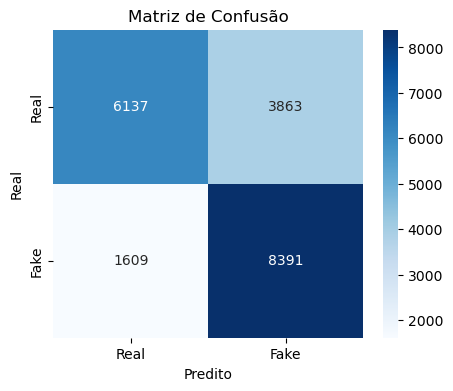


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.79      0.61      0.69     10000
        Fake       0.68      0.84      0.75     10000

    accuracy                           0.73     20000
   macro avg       0.74      0.73      0.72     20000
weighted avg       0.74      0.73      0.72     20000

AUC (ROC): 0.7928


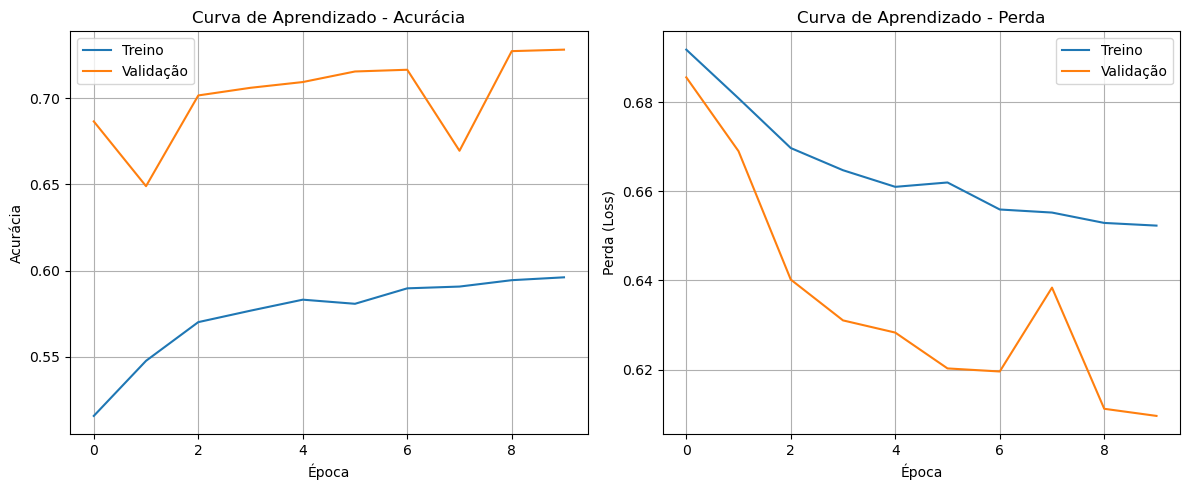

In [12]:
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Extrair labels verdadeiros do dataset de teste
y_test = []
for _, labels in test_ds:
    y_test.extend(labels.numpy())
y_test = np.array(y_test)

# Flatten y_pred_prob para garantir formato correto
y_pred_prob = y_pred_prob.ravel()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC (ROC): {roc_auc:.4f}")

plt.figure(figsize=(12, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Curva de Aprendizado - Acurácia")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.grid()

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Curva de Aprendizado - Perda")
plt.xlabel("Época")
plt.ylabel("Perda (Loss)")
plt.legend()
plt.grid()

plt.tight_layout()  
plt.show()

In [13]:
model.save("effct.keras")

SyntaxError: invalid character '“' (U+201C) (1702344125.py, line 1)